## Calculate coral bleach for Flower Garden Banks using variability-based threshold

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import netCDF4
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Read in preprocessed SST data and identify location

In [48]:
fp1 = '/glade/derecho/scratch/kristenk/sanctuaries_proc/CESM2_LE_1850to2100_monthly_FGB_Temp_15m-45m.nc'
ds = xr.open_dataset(fp1)
loc='Flower Garden Banks NMS'

In [49]:
ds

<xarray.Dataset>
Dimensions:           (time: 3012, member_id: 50)
Coordinates:
  * time              (time) object 1850-01-16 13:00:00.000001 ... 2100-12-16...
Dimensions without coordinates: member_id
Data variables:
    Temp_15m-45m_FGB  (member_id, time) float64 ...

In [50]:
nens = len(ds['Temp_15m-45m_FGB'].member_id)
nmon = len(ds['Temp_15m-45m_FGB'].time)
temps = ds['Temp_15m-45m_FGB'].values
nyear = int(nmon/12)
start_year = 1850

print("Dataset is", nmon, "months long (", nyear, " years, starting in", start_year, ") and has", nens, "ensemble members.")

Dataset is 3012 months long ( 251  years, starting in 1850 ) and has 50 ensemble members.


### Plot SST from a subset of data

In [51]:
ds.time

<xarray.DataArray 'time' (time: 3012)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 13, 0, 0, 1, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 13:00:00.000001 ... 2100-12-16 12:00:00
Attributes:
    long_name:  boundaries for time-averaging interval

In [52]:
deciyears = np.zeros((nmon),dtype=float) 

i = 0

for yr in np.arange(0,nyear,1):
    
    for mon in np.arange(1,13,1):
        
        deciyears[i] = 1850 + yr + mon/12 - 1/24

        i = i + 1

deciyears = xr.DataArray(deciyears,dims=('time'))

In [53]:
deciyears.values[3011]

2100.9583333333335

CPU times: user 38.3 ms, sys: 0 ns, total: 38.3 ms
Wall time: 38.6 ms


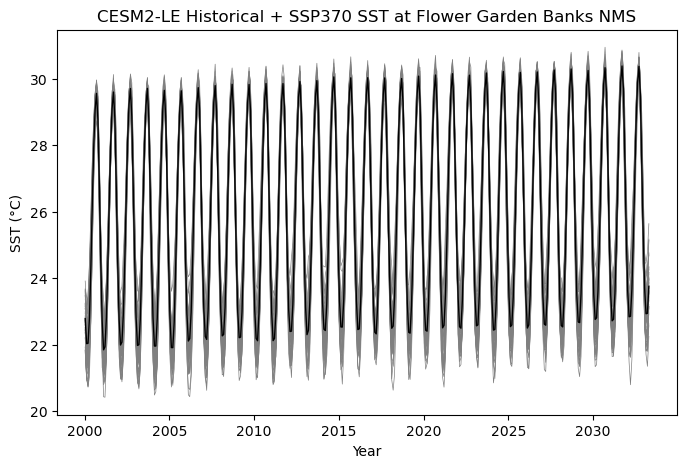

In [54]:
%%time

fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('CESM2-LE Historical + SSP370 SST at '+loc)

da_ensmean = ds['Temp_15m-45m_FGB'].mean(dim='member_id').isel(time=slice(1800,2200))

for mem in np.arange(0,50,1):
    #print(mem)
    ax.plot(deciyears.isel(time=slice(1800,2200)), ds['Temp_15m-45m_FGB'].isel(member_id=mem).isel(time=slice(1800,2200)),linewidth=0.5, color='gray')
ax.plot(deciyears.isel(time=slice(1800,2200)), da_ensmean,linewidth=1, color='black')
ax.set(ylabel='SST (°C)',xlabel='Year');

### Calculate static climatology

In [55]:
YEAR = np.arange(start_year, start_year + nyear)
YEAR

array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860,
       1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871,
       1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882,
       1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
       1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
       1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915,
       1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 20

In [56]:
### Make some empty arrays
ymax = np.zeros((nens,nyear,),dtype=float)      ### year maxes
MMM = np.zeros((nens,),dtype=float)             ### mean of max of monthly temps (?)
MMMstd = np.zeros((nens,),dtype=float)          ### standard deviation in max month mean (?)

### cycle through ensemble members
for e in range(0,nens):

    ### cycle through each year of the dataset
    for y in range(0,nyear):

        ### find the index of the first month of this year
        m1 = y * 12 ## find the index of the first month of this year

        ### put the maximum temperature from this year into the ymax array
        ymax[e,y] = np.max(temps[e,m1:m1+12])
        #ymax[e,y] = np.max(temps.isel(member_id=e, time=slice(m1,m1+12)).values)

        ### take a mean and standard deviation for a chuck of the ymax years
        MMM[e]=np.average(ymax[e,30:49]) ### why do we select these years for the static climatalogy?
        MMMstd[e]=np.std(ymax[e,30:49])
        
print("For the static climatology:")
print("Max monthly temp ranges from", min(MMM), "to", max(MMM))
print("Standard deviation of temp ranges from", min(MMMstd), "to", max(MMMstd))

For the static climatology:
Max monthly temp ranges from 28.900549118390167 to 29.199270842955283
Standard deviation of temp ranges from 0.13469437296094483 to 0.3263360016166308


### CALCULATE ROLLING CLIMATOLOGY - 50 year

In [57]:
nyadap = 50 ### 50 year adaptation rate

MMM50 = np.zeros((nens,nyear),dtype=float)

MMMstd50 = np.zeros((nens,nyear),dtype=float)

### cycle through ensemble members
for e in range(0,nens):

    ### cycle through each year of the dataset, starting 50 years in since it's a rolling climatology
    for year in range(nyadap,nyear):

        ### now ymax is a 50-year array of maximum of monthly temperatures
        ymax = np.zeros((nyadap),dtype=float)

        ### cycle through the 50 years needed to make the climatology (going backwards)
        for y in range(nyadap,0,-1):

            ### find the index of the first month
            m1 = (year - y) * 12

            ### and find max temp for each of these 50 years
            ymax[nyadap-y] = np.max(temps[e,m1:m1+12])

        ### now take average and standard deviation of this 50 year chunk
        MMM50[e,year]=np.average(ymax)
        MMMstd50[e,year]=np.std(ymax)

    print("ENS MEM:", e, "For first 50 years of rolling climatology:")
    print("Max monthly temp ranges from", min(MMM50[e,nyadap:nyadap+50]), "to", max(MMM50[e,nyadap:nyadap+50]))
    print("Standard deviation of temp ranges from", min(MMMstd50[e,nyadap:nyadap+50]), "to", max(MMMstd50[e,nyadap:nyadap+50]))
    print("---------------------")

ENS MEM: 0 For first 50 years of rolling climatology:
Max monthly temp ranges from 29.04208627866139 to 29.148471261213857
Standard deviation of temp ranges from 0.19796435619939562 to 0.23121987023747836
---------------------
ENS MEM: 1 For first 50 years of rolling climatology:
Max monthly temp ranges from 29.014411043558876 to 29.119780597371022
Standard deviation of temp ranges from 0.1814904658964872 to 0.2008727395352651
---------------------
ENS MEM: 2 For first 50 years of rolling climatology:
Max monthly temp ranges from 28.984063738410605 to 29.077625353200833
Standard deviation of temp ranges from 0.15661822588261623 to 0.2318649171845479
---------------------
ENS MEM: 3 For first 50 years of rolling climatology:
Max monthly temp ranges from 29.00536215020579 to 29.076442068307315
Standard deviation of temp ranges from 0.17165145592732173 to 0.22284561288238647
---------------------
ENS MEM: 4 For first 50 years of rolling climatology:
Max monthly temp ranges from 29.0596727

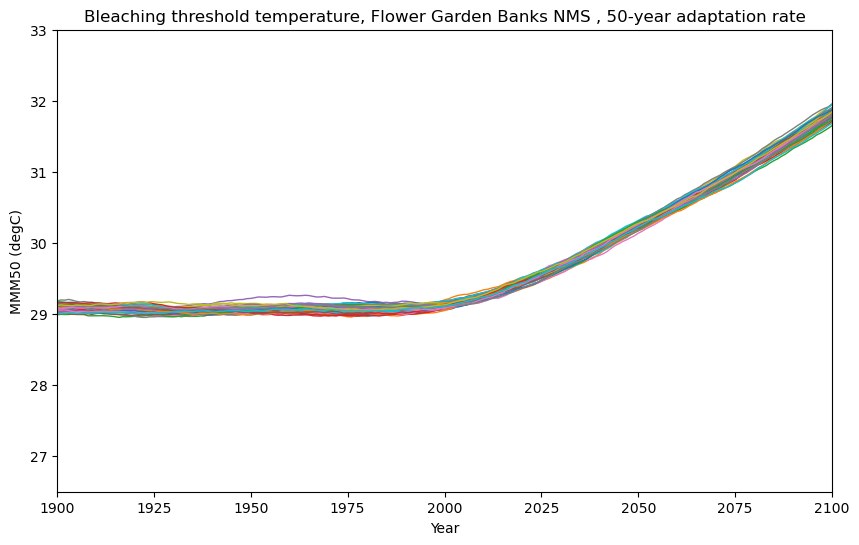

In [58]:
# PLOT THE DATA
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(1,1,1)
ax.set_title('Bleaching threshold temperature, '+ loc + ' , 50-year adaptation rate')

for e in range(0,nens):
    ax.plot(YEAR, MMM50[e,:], linewidth=1)
    ax.set(ylabel='MMM50 (degC)',xlabel='Year')
    ax.set(xlim=[1900,2100],ylim=[26.5,33]) #### NEED to adjust y-axis for each dataset

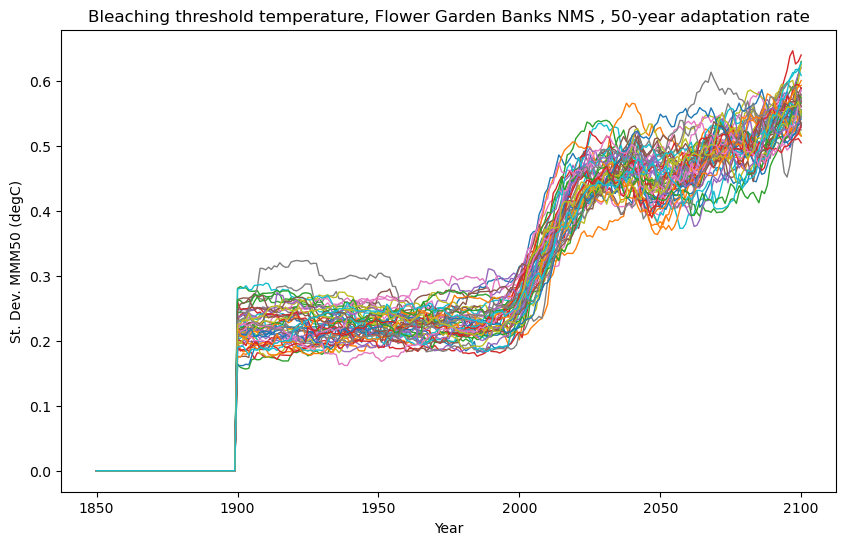

In [59]:
# PLOT THE DATA
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(1,1,1)
ax.set_title('Bleaching threshold temperature, '+ loc + ' , 50-year adaptation rate')

for e in range(0,nens):
    ax.plot(YEAR, MMMstd50[e,:], linewidth=1)
    ax.set(ylabel='St. Dev. MMM50 (degC)',xlabel='Year')

#ax.set(xlim=[1900,2100],ylim=[26.5,33]) #### NEED to adjust y-axis for each dataset

### Calculate Degree Heating Months (DHM) for Rolling climatology

In [60]:
#set up empty dataset for DHM and temp anomaly with 50-year adaptation
DHM50 = np.zeros((nens,nmon,),dtype=float) 
anomaly50 = np.zeros((nens,nmon,),dtype=float)

### the additional temperature threshold beyond climatological maximum that is included in DHM, this was set to zero in Joanie's code
threshold=0.0

### cycle through the ensemble members
for e in range(0,nens):

    ### cycle through all the months, excluding the first 50 years (50 years * 12 months/year)
    for m in range(nyadap*12,nmon):

        ### figure out the year
        y = int(m/12)

        ### now calculate how much this month exceeds the rolling 50-year climatological maximum, otherwise anomaly is zero
        if temps[e,m] > MMM50[e,y] + threshold:
            anomaly50[e,m] = temps[e,m] - (MMM50[e,y] + threshold)

### cycle through the ensemble members
for e in range(0,nens):

    ### cycle through all the months, summing over 3 month windows
    for m in range(3,nmon):
        DHM50[e,m] = np.sum(anomaly50[e,m-2:m+1]) ### why exclude first month (anomaly50[e,1:4])??
        #print(e,m,anomaly50[e,m],DHM50[e,m]);

### convert DHM50 to xarray and add it to the original dataset
ds['DHM50'] = xr.DataArray(DHM50,dims=('member_id','time'))

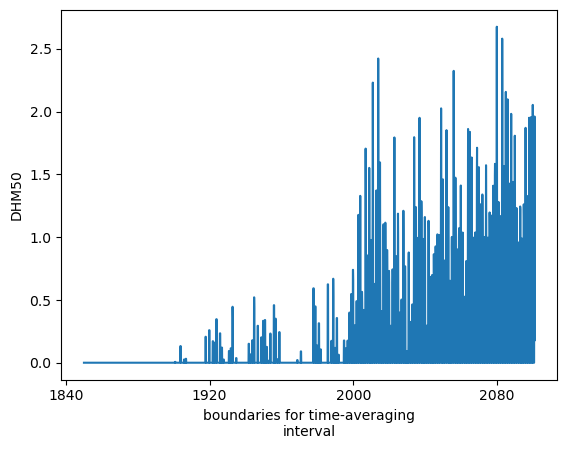

In [61]:
ds['DHM50'].isel(member_id=0).plot()

### Calculate max level of bleaching within each calendar year

This is where the code needs to be modified to be a variability-based threshold for bleaching

In [62]:
np.shape(MMMstd50) ## use MMMstd50 to normalize max_DHM_year (I think..)

(50, 251)

In [63]:
2*MMMstd

array([0.43148508, 0.39670847, 0.28682658, 0.3725384 , 0.38744597,
       0.40621966, 0.39976165, 0.513697  , 0.29913277, 0.52480142,
       0.34012886, 0.42672452, 0.54967617, 0.50107812, 0.35673024,
       0.29069157, 0.41372298, 0.49180009, 0.30798   , 0.46338247,
       0.40550021, 0.31549892, 0.54260653, 0.34332014, 0.49735895,
       0.43468095, 0.48138835, 0.3514698 , 0.48542386, 0.33398604,
       0.44142809, 0.405904  , 0.37253611, 0.46002252, 0.40922671,
       0.50320034, 0.38967909, 0.37677583, 0.46346675, 0.652672  ,
       0.41162922, 0.32836237, 0.58966514, 0.26938875, 0.46719877,
       0.44096527, 0.47216032, 0.34525153, 0.44207094, 0.42066059])

In [64]:
2*MMMstd50[1,100:200]

array([0.41060917, 0.41202883, 0.41333325, 0.41152308, 0.41322831,
       0.41135647, 0.42151075, 0.41734845, 0.42294285, 0.41840816,
       0.4053028 , 0.41217131, 0.41805798, 0.41365973, 0.41412185,
       0.4114737 , 0.42201896, 0.42147428, 0.40588036, 0.408698  ,
       0.40884635, 0.42112346, 0.4251616 , 0.42819146, 0.42721427,
       0.41970116, 0.41741658, 0.41809117, 0.41622108, 0.41659988,
       0.41760767, 0.41779098, 0.41910294, 0.41868324, 0.41592296,
       0.40947298, 0.41534441, 0.41541755, 0.43271354, 0.43765994,
       0.44111245, 0.44251087, 0.44777374, 0.44705781, 0.44677268,
       0.45509604, 0.42878445, 0.4297084 , 0.43282034, 0.43514319,
       0.40303109, 0.44900248, 0.48561987, 0.50560534, 0.54467424,
       0.56388789, 0.56653133, 0.57867219, 0.60285974, 0.62558279,
       0.65557613, 0.66278915, 0.65011973, 0.64472353, 0.65537763,
       0.67336702, 0.66352051, 0.6699895 , 0.66948109, 0.66945372,
       0.68323323, 0.70498399, 0.73018434, 0.73864067, 0.72222

In [65]:
### create empty arrays for bleaching indices
bleach = np.zeros((nens,nyear),dtype=int)
max_DHM_year = np.zeros((nens,nyear),dtype=float)
sum_DHM_year = np.zeros((nens,nyear),dtype=float)
bleachtot = np.zeros((nens,nyear),dtype=int)
bleachyear = np.zeros((nens),dtype=int)
bleachyear2 = np.zeros((nens),dtype=int)

### find monthly index starting point
mstart = nyadap*12

### cycle through the ensemble members
for e in range(0,nens):
    bleachyear[e]=0
    bleachyear2[e]=0

    print('ensemble member:', e)
    
    ### cycle through all the years, excluding the first 50 years (50 years * 12 months/year), grabbing 12 months at a time
    for m in range(mstart, nmon, 12):

        #figure out the year
        y = int(m/12)

        ### find out max degree heating months for this particular year
        max_DHM_year[e,y] = np.max(DHM50[e,m:m+12])
        bleach[e,y] = int(max_DHM_year[e,y])  ## DIVIDE BY 2*MMMstd50(e,y) for variability-based threshold ?????????????????!!!!!!

        ### sum up the degree heating months for this particular year
        sum_DHM_year[e,y] = np.sum(DHM50[e,m:m+12])
        bleachtot[e,y] = int(sum_DHM_year[e,y])
        
        ### figure out first years of severe and very severe bleaching (?????) is this the 6 and 9 DHM sum meaning?
        if (bleachtot[e,y] >= 6) and (bleachyear[e] == 0):
            bleachyear[e] = YEAR[y]
        if (bleachtot[e,y] >= 9) and (bleachyear2[e] == 0):
            bleachyear2[e] = YEAR[y]

    print('max bleach index (DHM):', max(bleach[e,:]))
    print('max bleachtot index (DHM sum):', max(bleachtot[e,:]))

    print('earliest year of severe bleaching:', bleachyear[e])
    print('earliest year of very severe bleaching:', bleachyear2[e])
    print('----------------------------')

ensemble member: 0
max bleach index (DHM): 2
max bleachtot index (DHM sum): 8
earliest year of severe bleaching: 2010
earliest year of very severe bleaching: 0
----------------------------
ensemble member: 1
max bleach index (DHM): 2
max bleachtot index (DHM sum): 8
earliest year of severe bleaching: 2037
earliest year of very severe bleaching: 0
----------------------------
ensemble member: 2
max bleach index (DHM): 2
max bleachtot index (DHM sum): 7
earliest year of severe bleaching: 2009
earliest year of very severe bleaching: 0
----------------------------
ensemble member: 3
max bleach index (DHM): 2
max bleachtot index (DHM sum): 7
earliest year of severe bleaching: 2037
earliest year of very severe bleaching: 0
----------------------------
ensemble member: 4
max bleach index (DHM): 2
max bleachtot index (DHM sum): 8
earliest year of severe bleaching: 2006
earliest year of very severe bleaching: 0
----------------------------
ensemble member: 5
max bleach index (DHM): 3
max bleach

In [66]:
bleach

array([[0, 0, 0, ..., 1, 2, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 1, 2],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 2, 1, 2]])

### Now make output dataset

In [67]:
ds_bleach = xr.Dataset()

ds_bleach['bleaching_index'] = xr.DataArray(bleach,dims=('member_id','time'))
ds_bleach['member_id'] = np.arange(1,nens+1,1)
ds_bleach['time'] = np.arange(start_year,start_year+nyear,1)

ds_bleach['DHM_max'] = xr.DataArray(max_DHM_year,dims=('member_id','time'))

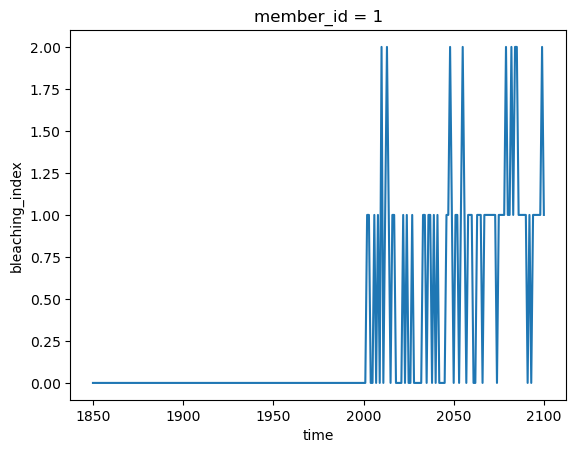

In [68]:
ds_bleach.bleaching_index.isel(member_id=0).plot()

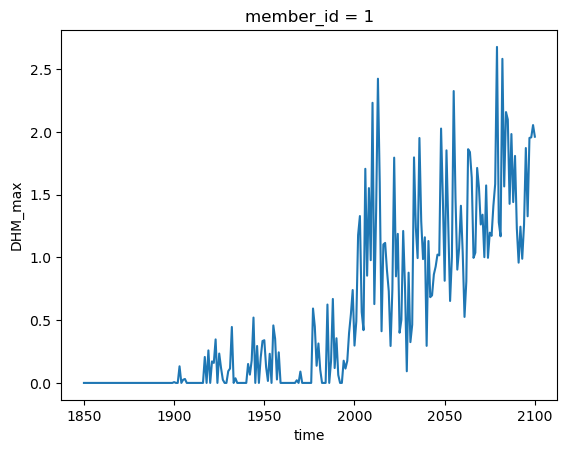

In [69]:
ds_bleach.DHM_max.isel(member_id=0).plot()

In [70]:
ds_bleach.time

<xarray.DataArray 'time' (time: 251)>
array([1850, 1851, 1852, ..., 2098, 2099, 2100])
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100

In [71]:
#colors = ['black','lightcoral','red','darkorange','gold','lightgreen','green','darkturquoise','dodgerblue','blue','darkviolet','magenta','hotpink']

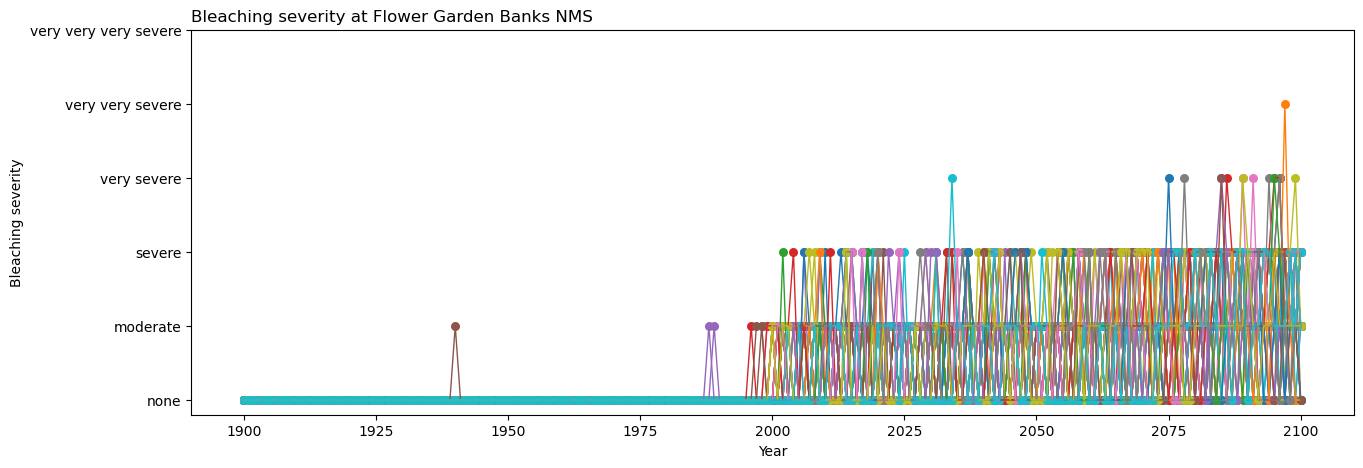

In [72]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Bleaching severity at ' + loc, loc='left')

for ens_mem in np.arange(0,50,1):
    
    ax.plot(ds_bleach.time.isel(time=slice(50,251)),ds_bleach.bleaching_index.isel(member_id=ens_mem,time=slice(50,251)),linewidth=1,label=str(ens_mem+1))
    ax.scatter(ds_bleach.time.isel(time=slice(50,251)),ds_bleach.bleaching_index.isel(member_id=ens_mem,time=slice(50,251)),s=30)
    
ax.set(ylabel='Bleaching severity',xlabel='Year')
labels=['none','moderate','severe','very severe','very very severe', 'very very very severe']
ax.set_yticks([0, 1, 2, 3, 4, 5]) 
ax.set_yticklabels(labels);
#ax.legend(title='Ensemble \n member');
#fig.savefig('/glade/work/kristenk/figs/SPuerto_Rico_13LMEmems_900to1150.png', bbox_inches='tight', dpi=300, format='png');


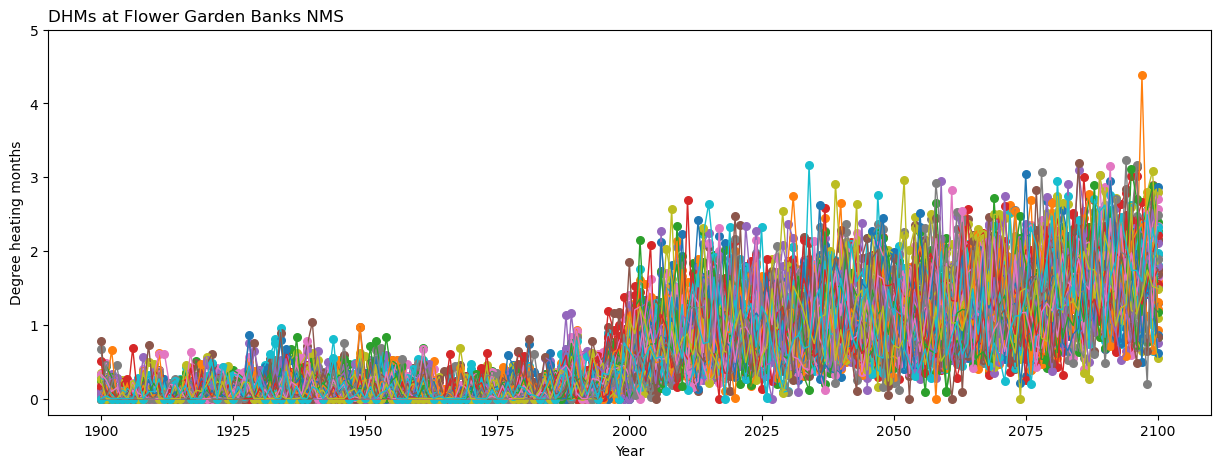

In [73]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('DHMs at ' + loc, loc='left')

for ens_mem in np.arange(0,nens,1):

    
    ax.plot(ds_bleach.time.isel(time=slice(50,251)),ds_bleach.DHM_max.isel(member_id=ens_mem,time=slice(50,251)),linewidth=1,label=str(ens_mem+1))
    ax.scatter(ds_bleach.time.isel(time=slice(50,251)),ds_bleach.DHM_max.isel(member_id=ens_mem,time=slice(50,251)),s=30)
    
ax.set(ylabel='Degree heating months',xlabel='Year')
labels=['none','moderate','severe','very severe','very very severe', 'very very very severe']
ax.set_yticks([0, 1, 2, 3, 4, 5]) 
#ax.set_yticklabels(labels);
#ax.legend(title='Ensemble \n member');
#fig.savefig('/glade/work/kristenk/figs/SPuerto_Rico_13LMEmems_900to1150.png', bbox_inches='tight', dpi=300, format='png');


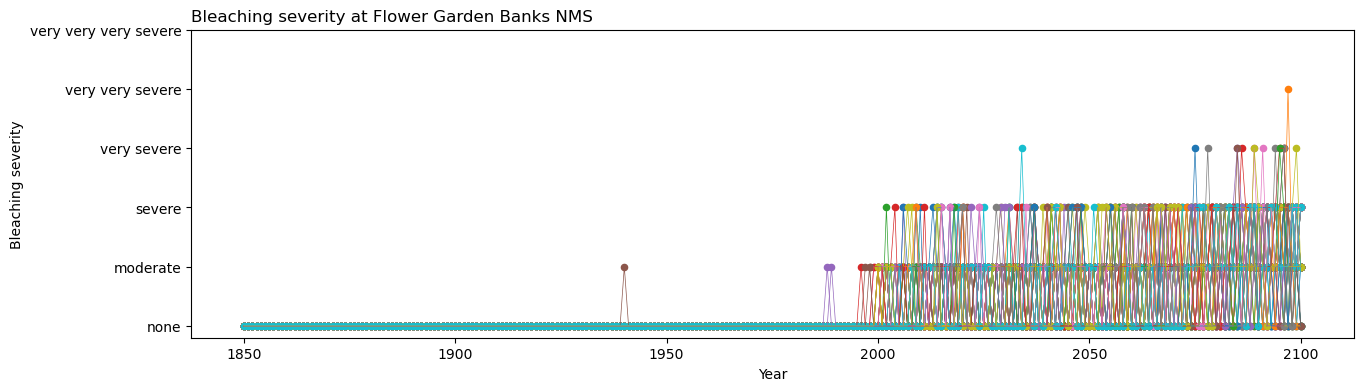

In [74]:
fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(1,1,1)
ax.set_title('Bleaching severity at ' + loc, loc='left')

for ens_mem in np.arange(0,nens,1):

    
    ax.plot(ds_bleach.time,ds_bleach.bleaching_index.isel(member_id=ens_mem),linewidth=0.5,label=str(ens_mem+1))
    ax.scatter(ds_bleach.time,ds_bleach.bleaching_index.isel(member_id=ens_mem),s=20)
    
ax.set(ylabel='Bleaching severity',xlabel='Year')
labels=['none','moderate','severe','very severe','very very severe', 'very very very severe']
ax.set_yticks([0, 1, 2, 3, 4, 5]) 
ax.set_yticklabels(labels);

#ax.legend(title='Ensemble \n member');

#fig.savefig('/glade/work/kristenk/figs/SPuerto_Rico_13LMEmems_900to2005.png', bbox_inches='tight', dpi=300, format='png');


In [75]:
#For each year, calculate the number of ensemble members at each bleaching level

numens0= np.zeros((nyear),dtype=int)
numens1= np.zeros((nyear),dtype=int)
numens2= np.zeros((nyear),dtype=int)
numens3= np.zeros((nyear),dtype=int)
numens4= np.zeros((nyear),dtype=int)
numens5= np.zeros((nyear),dtype=int)
numens6= np.zeros((nyear),dtype=int)

for y in range(0,nyear):
    numens0[y]=np.size(np.where(bleach[:,y]==0))
    numens1[y]=np.size(np.where(bleach[:,y]==1))
    numens2[y]=np.size(np.where(bleach[:,y]==2))
    numens3[y]=np.size(np.where(bleach[:,y]==3))
    numens4[y]=np.size(np.where(bleach[:,y]==4))
    numens5[y]=np.size(np.where(bleach[:,y]==5))
    numens6[y]=np.size(np.where(bleach[:,y]==6))

numenstot=np.zeros((nyear),dtype=int)
for y in range(0,nyear):
    numenstot[y]=numens0[y]+numens1[y]+numens2[y]+numens3[y]+numens4[y]+numens5[y]
    
print("number ens with bleaching = 0")
print(numens0)
print("number ens with bleaching = 1")
print(numens1)
print("number ens with bleaching = 2")
print(numens2)
print("number ens with bleaching = 3")
print(numens3)
print("number ens with bleaching = 4")
print(numens4)
print("number ens with bleaching = 5")
print(numens5)
print("number ens with bleaching = 6")
print(numens6)
print("SUM")
print(numenstot)


number ens with bleaching = 0
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 49 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 49 49 50 50 50 50
 50 50 49 49 48 48 41 43 29 40 42 44 39 36 35 38 38 32 28 23 21 27 30 32
 30 29 31 27 32 26 25 29 28 25 30 33 29 25 27 29 28 21 18 18 18 24 22 20
 17 25 23 26 21 19 18 25 20 19 19 27 16 15 16 18 22 22 20 24 15 16  9 13
 16 15 20 16  7  9 15 18 15 12 13 15 10 10  9  9 13  6 10  6  9  5  3  2
  9  5  7  4  6  6  8  6  4  4  8]
number ens with bleaching = 1
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  

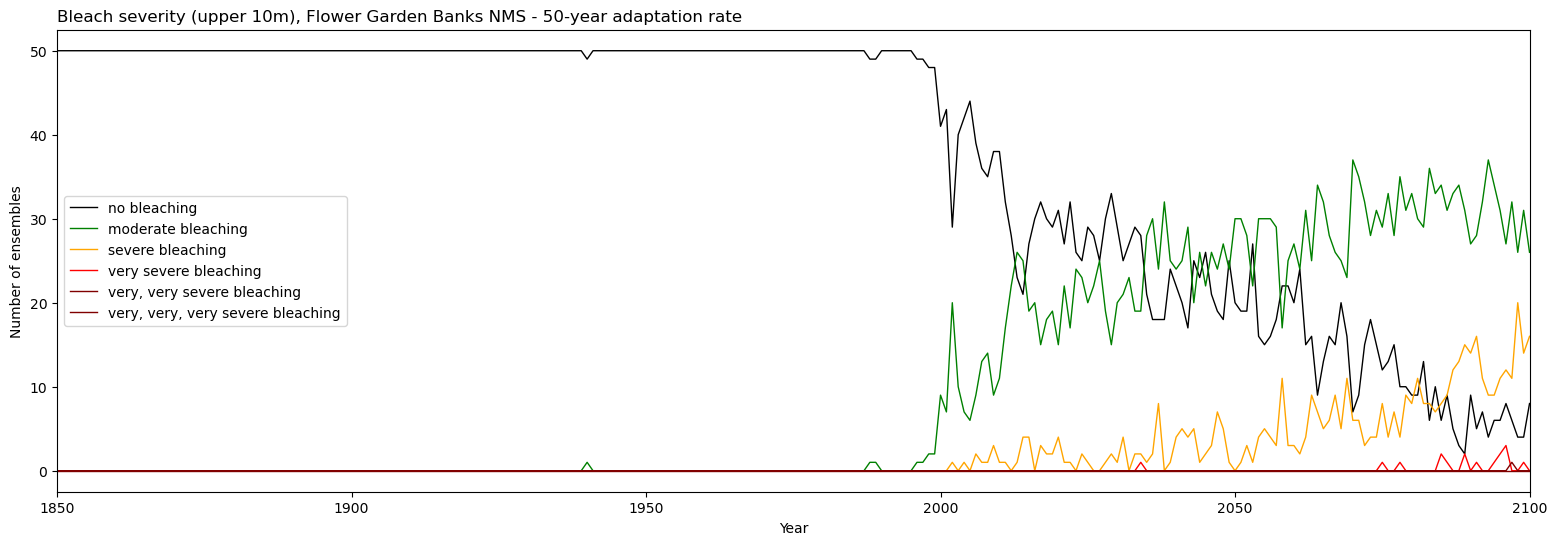

In [76]:
# PLOT THE Bleaching data for each ensemble member

fig = plt.figure(figsize=(19,6))

ax = fig.add_subplot(1,1,1)
ax.set_title('Bleach severity (upper 10m), ' + loc + ' - 50-year adaptation rate', loc='left')

ax.plot(YEAR, numens0, linewidth=1, color='black',label='no bleaching')
ax.plot(YEAR, numens1, linewidth=1, color='green', label='moderate bleaching')
ax.plot(YEAR, numens2, linewidth=1, color='orange', label='severe bleaching')
ax.plot(YEAR, numens3, linewidth=1, color='red', label='very severe bleaching')
ax.plot(YEAR, numens4, linewidth=1, color='maroon', label='very, very severe bleaching')
ax.plot(YEAR, numens5, linewidth=1, color='maroon', label='very, very, very severe bleaching')

ax.set(ylabel='Number of ensembles',xlabel='Year')
ax.set(xlim=[start_year,2100])

ax.legend();


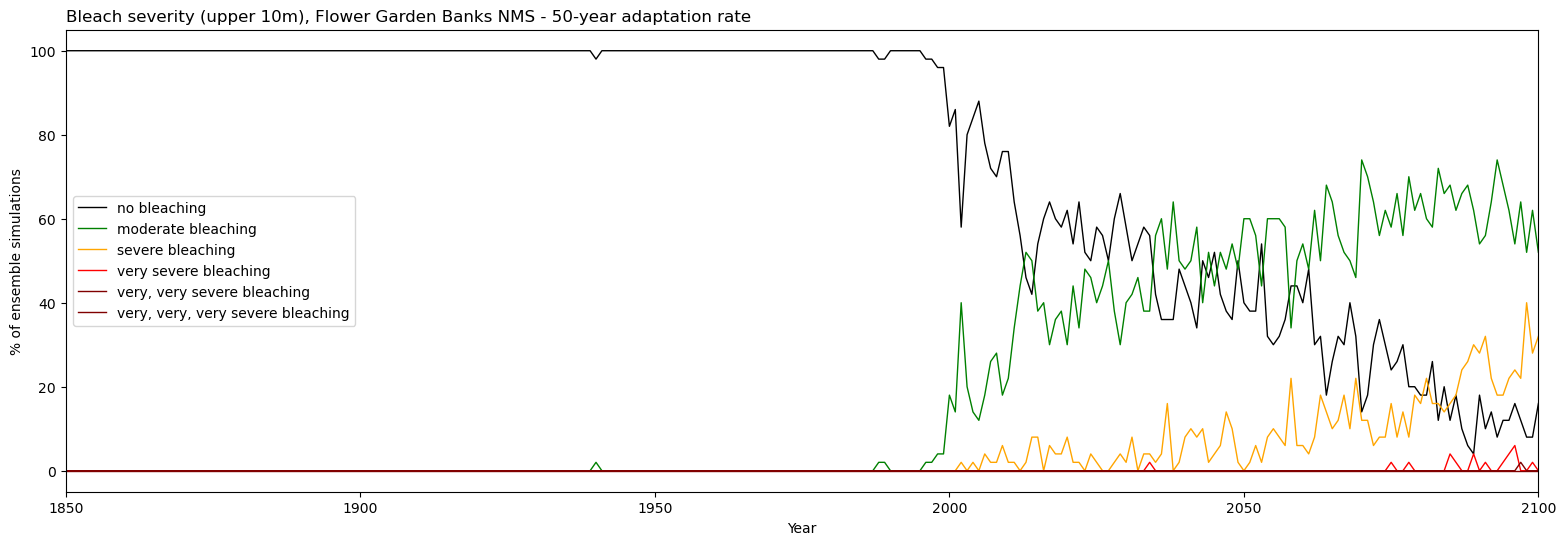

In [77]:
# PLOT THE Bleaching data for each ensemble member

fig = plt.figure(figsize=(19,6))

ax = fig.add_subplot(1,1,1)
ax.set_title('Bleach severity (upper 10m), ' + loc + ' - 50-year adaptation rate', loc='left')

ax.plot(YEAR, numens0/nens*100, linewidth=1, color='black',label='no bleaching')
ax.plot(YEAR, numens1/nens*100, linewidth=1, color='green', label='moderate bleaching')
ax.plot(YEAR, numens2/nens*100, linewidth=1, color='orange', label='severe bleaching')
ax.plot(YEAR, numens3/nens*100, linewidth=1, color='red', label='very severe bleaching')
ax.plot(YEAR, numens4/nens*100, linewidth=1, color='maroon', label='very, very severe bleaching')
ax.plot(YEAR, numens5/nens*100, linewidth=1, color='maroon', label='very, very, very severe bleaching')
ax.set(ylabel='% of ensemble simulations',xlabel='Year')
ax.set(xlim=[start_year,2100])

ax.legend();


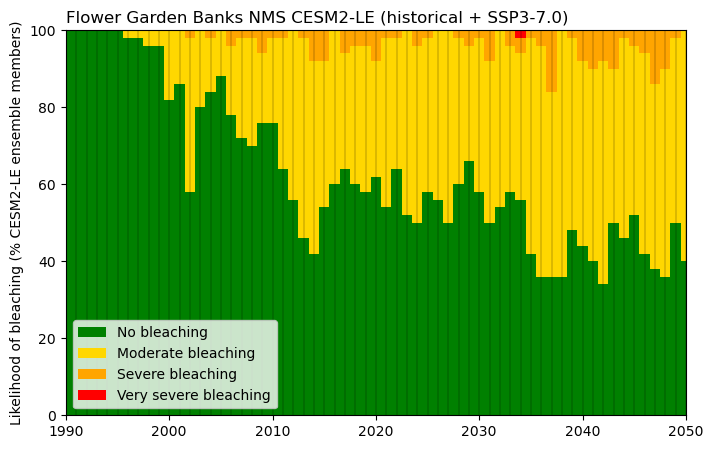

In [78]:
width = 1       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(8,5))
ax.set_title(loc+ ' CESM2-LE (historical + SSP3-7.0)', loc='left',fontsize=12)
ax.bar(YEAR, (numens0/nens*100), width, label='No bleaching', color='green')
ax.bar(YEAR, (numens1/nens*100), width, bottom=(numens0/nens*100), label='Moderate bleaching', color='gold')
ax.bar(YEAR, (numens2/nens*100), width, bottom=(numens0/nens*100)+(numens1/nens*100), label='Severe bleaching', color='orange')
ax.bar(YEAR, ((numens3+numens4+numens5)/nens*100), width, bottom=(numens0/nens*100)+(numens1/nens*100)+(numens2/nens*100), label='Very severe bleaching', color='red')
ax.set(xlim=[1990,2050])

for yr in YEAR:
    ax.axvline(yr,linewidth=0.2,color='black')
ax.set_ylabel('Likelihood of bleaching (% CESM2-LE ensemble members)')
ax.legend()

#fig.savefig('/glade/work/kristenk/figs/South_PuertoRico-Coral_bleaching_900AD-to-2005_LME.png', bbox_inches='tight', dpi=300, format='png');

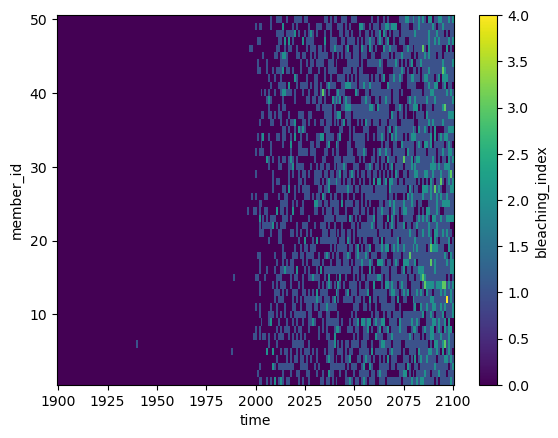

In [79]:
ds_bleach.bleaching_index.isel(time=slice(50,251)).plot()

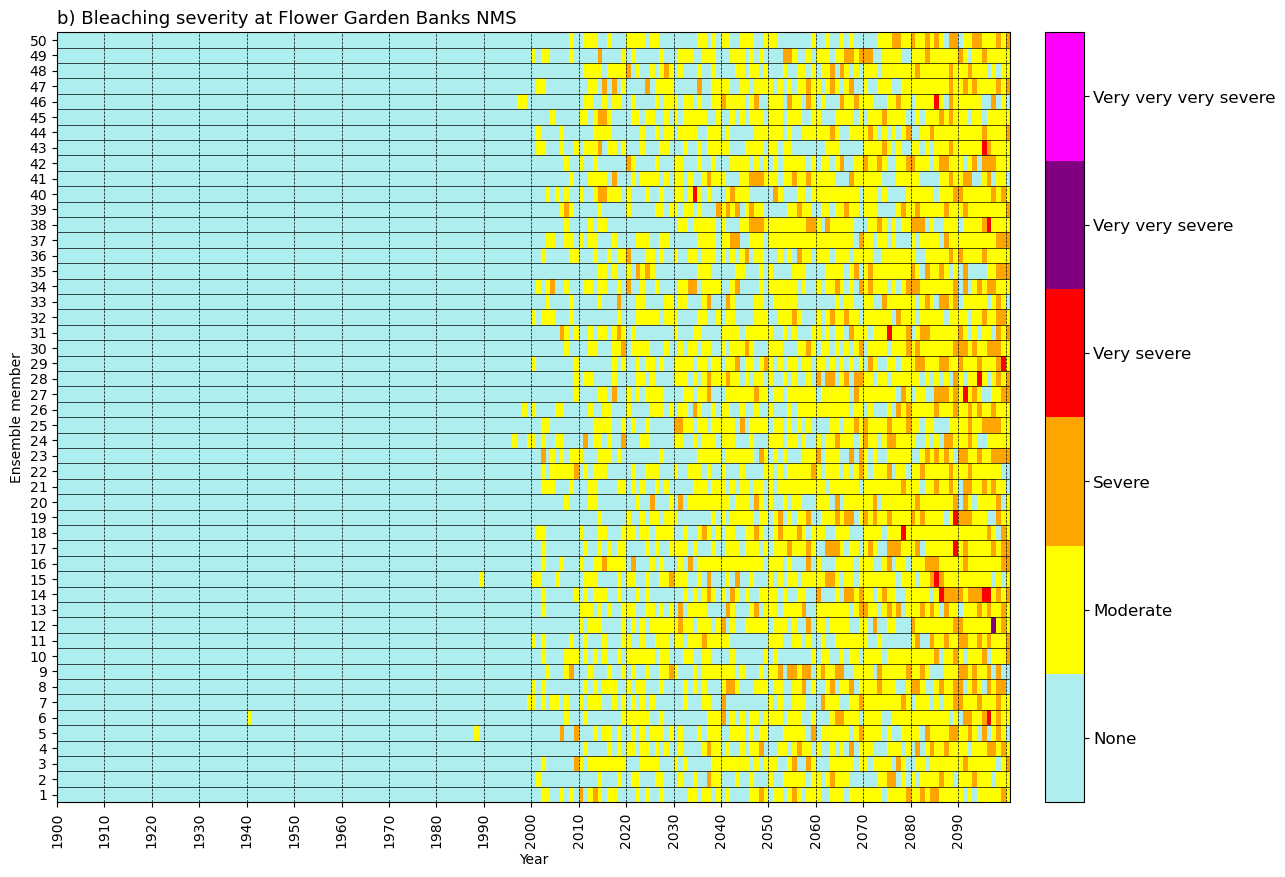

In [80]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(1,1,1)

ax.set_title('b) Bleaching severity at '+ loc, loc='left', fontsize='13')

colorlist = ['paleturquoise', 'yellow', 'orange', 'red', 'purple','magenta']

cmap = matplotlib.colors.LinearSegmentedColormap.from_list('bleach', colorlist, N=6)

pc=ax.pcolormesh(ds_bleach.bleaching_index.isel(time=slice(50,nyear)),cmap=cmap,vmin=0,vmax=6)
ax.set_ylabel('Ensemble member')
ax.set_xlabel('Year')

cbar = fig.colorbar(pc, ax=ax, ticks=[0.5,1.5,2.5,3.5,4.5,5.5], pad=0.03)
cbar.ax.set_yticklabels(['None', 'Moderate', 'Severe', 'Very severe', 'Very very severe','Very very very severe'], fontsize=12) 

ax.set_yticks(ds_bleach.member_id.values-0.5)
ax.set_yticklabels(ds_bleach.member_id.values)

[ax.axhline(y=i, linewidth=0.5, color='black') for i in np.arange(1,nens+1,1)]

[ax.axvline(x=i, linewidth=0.5, linestyle='--',color='black') for i in np.arange(10,nyear-50,10)]

ax.set_xticks(np.arange(0,200,10));
ax.set_xticklabels(np.arange(1900,2100,10),rotation=90);

#fig.savefig('/glade/work/kristenk/figs/South_PuertoRico-Coral_bleaching_heatmap.png', bbox_inches='tight', dpi=300, format='png');

### Create rolling averages to assess severity of bleaching events several years in a row

In [81]:
start_i = 5
end_i = 245

moving_avg = np.full((end_i - start_i + 1),-99.)
moving_avg_dhm = np.full((end_i - start_i + 1),-99.)
time_center = np.full((end_i - start_i + 1),-99)

for ts in np.arange(start_i, end_i + 1,1):

    ### Do coral bleaching index
    avg = ds_bleach.bleaching_index.isel(time=slice(ts-5,ts+5)).mean(dim=('time','member_id')).values
    #print('year =', ts+900, '   avg=', avg)

    moving_avg[ts-5] = avg

    ### Do DHM
    avg = ds_bleach.DHM_max.isel(time=slice(ts-5,ts+5)).mean(dim=('time','member_id')).values

    moving_avg_dhm[ts-5] = avg
    
    time_center[ts-5] = ts+1850

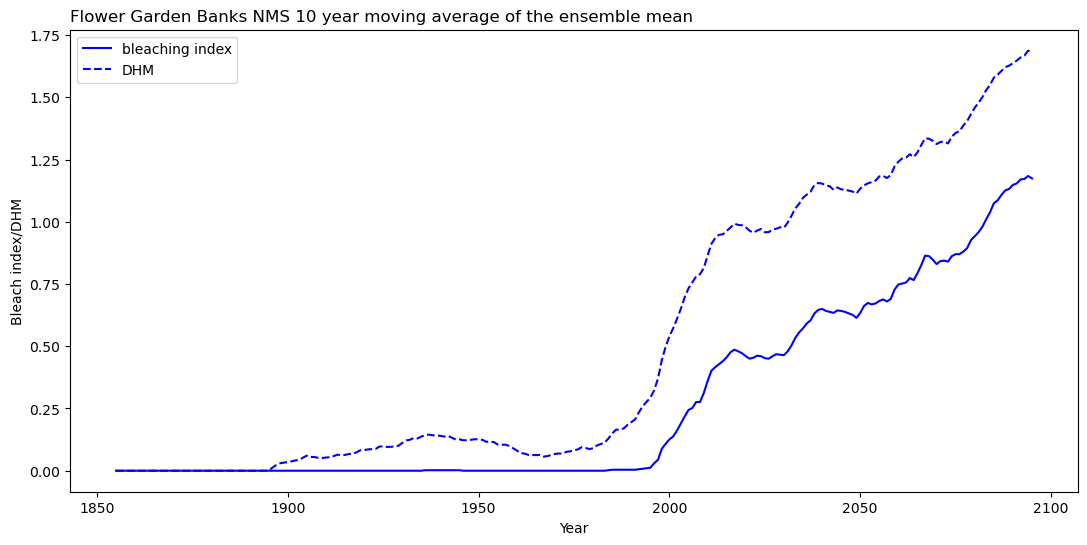

In [82]:
fig = plt.figure(figsize=(13,6))

ax = fig.add_subplot(1,1,1)
ax.set_title(loc+' 10 year moving average of the ensemble mean', loc='left')
ax.set_ylabel('Bleach index/DHM')
ax.set_xlabel('Year')

ax.plot(time_center,moving_avg,color='blue',label='bleaching index')

ax.plot(time_center,moving_avg_dhm,color='blue', linestyle='--',label='DHM')

ax.legend();
#ax.plot(npr_mean_val.time,npr_mean_val,color='red')

In [83]:
start_i = 5
end_i = 245

moving_avg = np.full((end_i - start_i + 1,nens),-99.)

moving_avg_dhm = np.full((end_i - start_i + 1,nens),-99.)

time_center = np.full((end_i - start_i + 1),-99)

for ts in np.arange(start_i, end_i + 1,1):

    for em in np.arange(0,nens,1):
        
        ### bleach metric
        avg = ds_bleach.bleaching_index.isel(member_id=em,time=slice(ts-5,ts+5)).mean(dim='time').values
    
        moving_avg[ts-5,em] = avg

        ### DHMs
        avg = ds_bleach.DHM_max.isel(member_id=em,time=slice(ts-5,ts+5)).mean(dim='time').values
    
        moving_avg_dhm[ts-5,em] = avg
        
        time_center[ts-5] = ts+1850

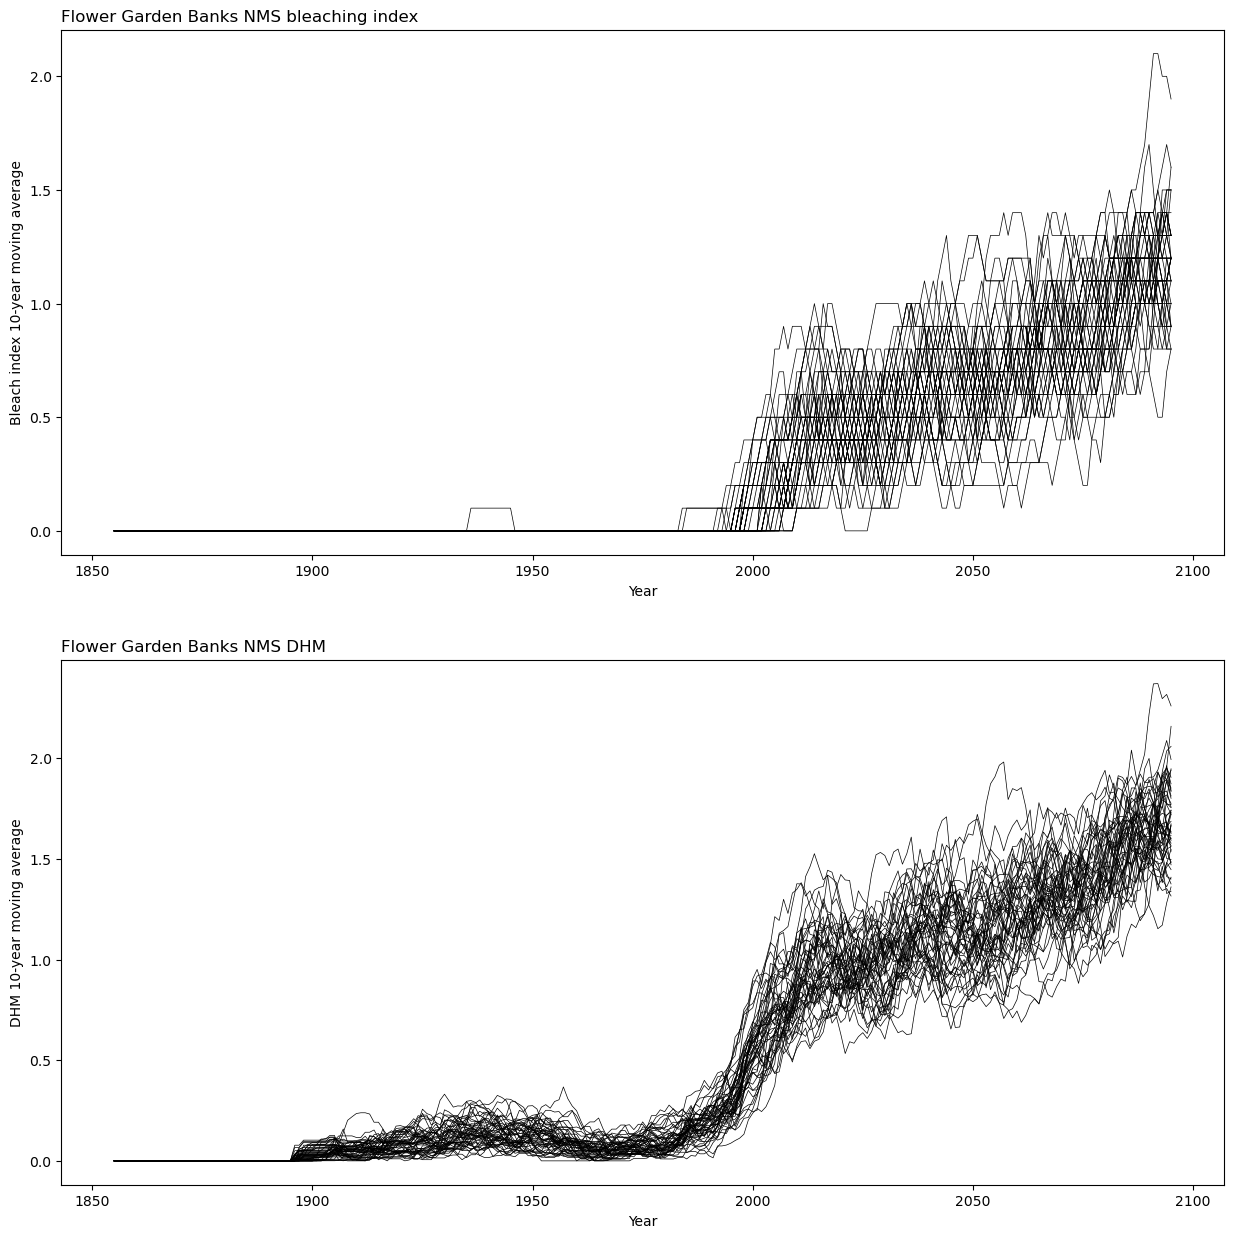

In [84]:
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(2,1,1)
ax.set_title(loc+' bleaching index', loc='left')
ax.set_ylabel('Bleach index 10-year moving average')
ax.set_xlabel('Year')
for em in np.arange(0,nens,1):
    ax.plot(time_center,moving_avg[:,em],color='black',linewidth=0.5)

ax = fig.add_subplot(2,1,2)
ax.set_title(loc+' DHM', loc='left')
ax.set_ylabel('DHM 10-year moving average')
ax.set_xlabel('Year')
for em in np.arange(0,nens,1):
    ax.plot(time_center,moving_avg_dhm[:,em],color='black',linewidth=0.5)

### Make these moving averages in xarray data arrays, and then calculate a few more metrics

In [85]:
moving_avg = xr.DataArray(moving_avg,dims=('time','member_id'))
moving_avg_dhm = xr.DataArray(moving_avg_dhm,dims=('time','member_id'))

In [86]:
moving_avg_ensmax = moving_avg.max(dim='member_id')
moving_avg_dhm_ensmax = moving_avg_dhm.max(dim='member_id')

In [87]:
moving_avg_ensmin = moving_avg.min(dim='member_id')
moving_avg_dhm_ensmin = moving_avg_dhm.min(dim='member_id')

In [88]:
moving_avg_ensmean = moving_avg.mean(dim='member_id')
moving_avg_dhm_ensmean = moving_avg_dhm.mean(dim='member_id')

In [89]:
moving_avg_ensstd = moving_avg.std(dim='member_id')
moving_avg_dhm_ensstd = moving_avg_dhm.std(dim='member_id')

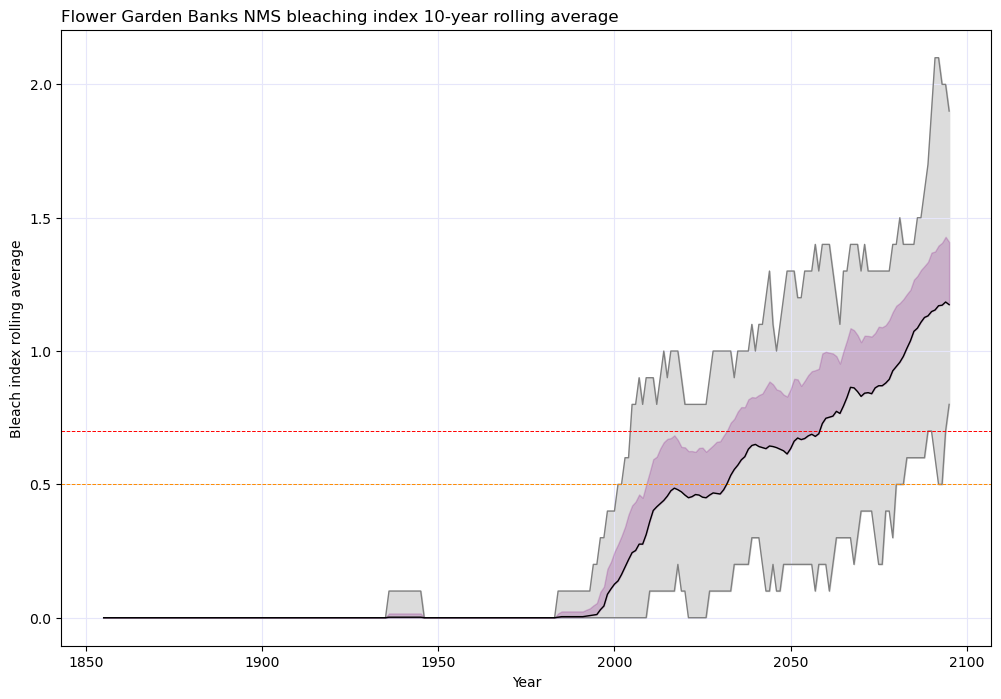

In [90]:
fig = plt.figure(figsize=(12,8))

##################################
ax = fig.add_subplot(1,1,1)
ax.set_title(loc+' bleaching index 10-year rolling average', loc='left')
ax.set_ylabel('Bleach index rolling average')
ax.set_xlabel('Year')

ax.plot(time_center,moving_avg_ensmean,color='black',linewidth=1,zorder=3)
ax.plot(time_center,moving_avg_ensmax,color='gray',linewidth=1,zorder=2)
ax.plot(time_center,moving_avg_ensmin,color='gray',linewidth=1,zorder=2);
ax.fill_between(time_center,moving_avg_ensmean,moving_avg_ensmean+ moving_avg_ensstd,color='purple',alpha=0.2,zorder=2)
ax.xaxis.grid(True, which='major',color='lavender',zorder=0)
ax.yaxis.grid(False, which='major',color='lavender',zorder=0)
ax.axhline(0.5,color='darkorange',linewidth=0.7,linestyle='--', label='persistent')
ax.axhline(0.7,color='red',linewidth=0.7,linestyle='--', label='unsustainable')

ax.fill_between(time_center, moving_avg_ensmin, moving_avg_ensmax, color='gainsboro', zorder=1);



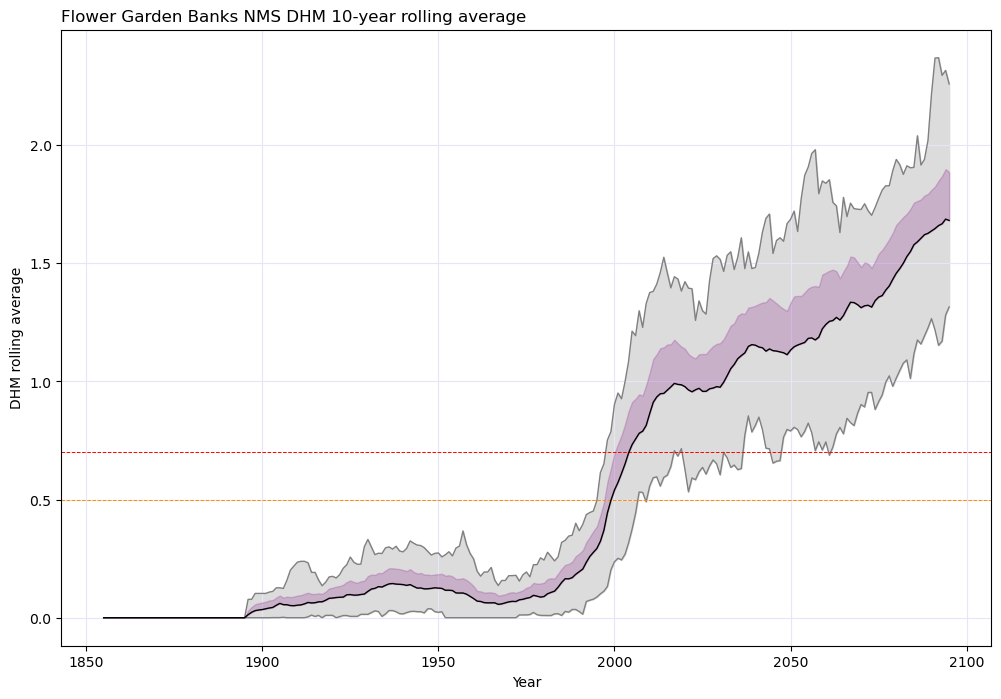

In [91]:
fig = plt.figure(figsize=(12,8))

##################################
ax = fig.add_subplot(1,1,1)
ax.set_title(loc+' DHM 10-year rolling average', loc='left')
ax.set_ylabel('DHM rolling average')
ax.set_xlabel('Year')

ax.plot(time_center,moving_avg_dhm_ensmean,color='black',linewidth=1,zorder=3)
ax.plot(time_center,moving_avg_dhm_ensmax,color='gray',linewidth=1,zorder=2)
ax.plot(time_center,moving_avg_dhm_ensmin,color='gray',linewidth=1,zorder=2);
ax.fill_between(time_center,moving_avg_dhm_ensmean,moving_avg_dhm_ensmean+ moving_avg_dhm_ensstd,color='purple',alpha=0.2,zorder=2)
ax.xaxis.grid(True, which='major',color='lavender',zorder=0)
ax.yaxis.grid(False, which='major',color='lavender',zorder=0)
ax.axhline(0.5,color='darkorange',linewidth=0.7,linestyle='--', label='persistent')
ax.axhline(0.7,color='red',linewidth=0.7,linestyle='--', label='unsustainable')

ax.fill_between(time_center, moving_avg_dhm_ensmin, moving_avg_dhm_ensmax, color='gainsboro', zorder=1);



### Write out netcdf of bleaching

In [92]:
ds_bleach.to_netcdf('/glade/derecho/scratch/kristenk/sanctuaries_proc/FGB_bleaching_metrics.nc', mode='w')